# Decomposing Shared Parameter Gradients in RNNs

## 1. Introduction

### 1.1 Motivation
In one of my first introductions to deep learning, I heard about the problem of vanishing and exploding gradients. Now, this can be a problem with any deep neural network, but it is particularly bad with RNNs due to their long recursive structure.

Since prevailing methods of optimization are gradient based, this problem obviously makes optimization hard because you would expect that these exponentially large or exponentially small gradients would prevent these models from converging (moving too fast, or moving too slowly). The problem is exacerbated when different layers share parameters. If there was no parameter sharing, updates might be super small, but after enough steps it would find a good minimum. But since RNNs do have parameter sharing, there is nothing preventing the later layers from having dominant gradient steps, and "overruling" any directions that early layers might want to move in.

This line of reasoning motivated my optimization philosophy. Different layers in an RNN might have different "voting power," over the direction the underlying parameters should update. For instance, an earlier layer may have "voting power" that is much too small if the gradient is vanishing. Maybe it would be helpful to give all the layers the same "voting power," so that repeated chain rules no longer deflate/inflate a layer's update direction. This is the idea we explore in this notebook.

### 1.2 Related Work

Lots of work was done in the years (2012-2016) on the optimization of RNNs. One paper that particularly stands out in RNN optimization is "On the difficulty of training Recurrent Neural Networks" (Pascanu et. al, 2012), which introduced a clipping strategy to prevent gradients from exploding, and a regularizer to prevent gradients from being too small.

Another paper addressing this problem is "Unitary Evolution Recurrent Neural Networks" (Arjovsky et. al, 2016). This paper suggested that in the equation $h_{t+1} = \sigma(W_{hh}h_t + V_{ih}x_{t+1})$, $W_{hh}$ should be unitary, as this is the term that gets multiplies in the gradient computations. Since unitary matrices preserve vector norm, there will be no exploding or vanishing gradients.

Another paper studied the effects of normalizing gradients for every layer in deep neural networks (not including RNNs), "Block-Normalized Gradient Method" (Wei Yu et. al, 2017). In this paper they consider $\tilde y = f_n(f_{n-1}(...f_1(x)))$, and calculate $g^i_t = \frac{dL}{d\theta_i}$. Then they re-assign $g^i_t \leftarrow \frac{g^i_t}{||g^i_t||_2}$, and then they update $w_{t+1} = w_t - \tau_t \circ g_t$, so $\tau$ essentially controls the magnitude of the gradient, and we always trust the direction of the gradient. This paper takes on the same optimization philosophy that our notebook investigates, that parameter updates shouldn't decay or explode too quickly.

### 1.3 Overview

In the traditional backpropagation with SGD in RNNs, you add up all the cost functions $C(y, \tilde y) = \sum_t C(y_t, \tilde y_t)$, where $\tilde y_t$ is the prediction generated using only inputs from $(x_i){i\leq t}$. In order to understand our optimization scheme, we first consider losses one at a time (this technically isn't how the optimization scheme is implemented exactly, but its a useful simplification for now). 

Also, just for the following paragraph, we will be thinking of an RNN as a deep neural network, rather than a recursive neural network that has shared parameters. This allows us to talk about perturbing parameters in one layer without perturbing that parameter in another layer.

Let $\theta_i$ be the parameters at layer $i << t_0$

If we take the gradient $\frac{dC_{t_0}}{d\theta_i}$, there is a vanishing/exploding gradient problem here, i.e. perturbing parameters from many layers back either have a very large or very small effect on the loss function (the gradient is super small). So if we adopt the idea from Wei Yu et. al and normalize the gradient, then the direction of the step is preserved, but the magnitude is controlled (the magnitude of the update would be around the size of the learning rate). This ensures we always make reasonable progress, not too slow, not too quick, towards the minimum. Tying this back to section 1.1, by making normalizing these magnitudes, we essentially give each layer the same "voting power."

If this were a deep neural network, we would update $\theta_i \leftarrow \theta_i - \eta \frac{dC_{t_0}/d\theta_i}{||dC_{t_0}/d\theta_i||_p}$. However, since RNNs do have parameter sharing, the update we just wrote makes no sense (the parameters in each layer of the RNN are the same, so they must be updated to be the same value). The way the actual update would work would be collect all the directions $arr[i] = \frac{dC_{t_0}/d\theta_i}{||dC_{t_0}/d\theta_i||_p}$, and then update $\theta \leftarrow \theta - \eta * \sum_i arr[i]$. Each term $i$ in the sum has an approximately equal magnitude, cementing the idea that each layer has an equal "vote."

I hypothesize that an approach like this will help RNNs have a longer memory (a longstanding problem of RNNs), because now the memory layer ($i << t_0$) will have an equal say in the parameter updates, whereas before, its "vote" might have been very small.

** Comments to self (ignore if its confusing), maybe it doesn't make sense to add all these steps together, since moving a certain direction in layer 1 doesn't mean you necessarily want to move a certain direction in layer 10 (but you have to because of parameter sharing). Maybe a more nuanced rule would be decide which layer should get the largest update based on some SNR of the gradients calculated. For instance, you could weight the gradient updates instead of summing them, where the weight would increase with higher SNR of gradients (maybe cosine similarity). This is kind of what SGD does, because gradients with higher SNR move in the same direction more times, however SGD still steps with a miniscule step size when the layer is far away, which is what my algorithm would attempt to fix **

## 2. Method
In order to get more technical, we introduce the Adam optimizer (used to help implement the optimization philosophy) and a mathematical decomposition of RNN gradients (which makes the interpretation of RNNs as a deep neural network more rigorous).

### 2.1 Adam

A recent paper -- "In Search of Adam's Secret Sauce" (Orvieto, Gower, 2025) -- brought to my attention a nice interpretation the Adam update rule, which I'll copy here.

$$g_k = \frac{dL}{dw}$$
$$m_k = \beta_1 * m_{k-1} + (1-\beta_1) * g_k$$
$$v_k = \beta_2 * v_{k-1} + (1-\beta_2) * g_k^2$$ 
$$w_{k+1} = w_k - \eta \frac{m_k}{\sqrt{v_k} + \epsilon}$$

One thing that you notice in this formulation, is that the update rule is independent of the scale of the gradients. The paper brings up that the update is essentially the same as $\frac{sign(g_k)}{\sqrt{1 + Var(g_k)/E[g_k]^2}}$. Note the signal to noise ratio in the denominator.

We will be using the Adam optimizer to do the "normalization" ($\frac{dC_{t_0}/d\theta_i}{||dC_{t_0}/d\theta_i||_p}$) for us, because it accomplishes the same thing (making updates have a size similar to the learning rate), but we don't use the exact formula in parentheses, because that formula isn't guaranteed to converge to an update of $0$. In other words, using Adam appears more principled at a first glance. More details on this exact implementation in 2.2.

### 2.2 Gradient Decomposition

Another notion I want to bring up is the decomposition of gradients briefly mentioned in Pascanu et. al.

$$h_t = W_{hh}\sigma(h_{t-1}) + W_{ih}x_t + b$$
$$\frac{dL}{d\theta} = \sum_{i=1}^T \frac{dL_t}{d\theta}$$
$$\frac{dL_t}{d\theta} = \sum_{k=1}^t (\frac{dL_t}{dx_t}\frac{dx_t}{dx_k}\frac{d^+x_k}{d\theta})$$
$$\frac{dx_t}{dx_k} = \Pi_{i=k+1}^t \frac{dx_i}{dx_{i-1}} = \Pi_{i=k+1}^t W_{hh}^Tdiag(\sigma'(x_{i-1}))$$

Here, $\frac{d^+x_k}{d\theta}$ is the "immediate" partial derivative of $x_k$ wrt $\theta$, i.e., $\frac{d^+x_k}{d\theta}$ where we pretend $x_{k-1}$ is a constant. This is the more rigorous way to think of RNN gradients, rather than pretending it is a deep neural network.

Revisiting the simplified example in 1.3, where you only consider $\frac{dC_{t_0}}{d\theta}$, $\frac{dC_{t_0}}{d\theta_i}$ would correspond to $\frac{dL_t}{dx_t}\frac{dx_t}{dx_k}\frac{d^+x_k}{d\theta} = \frac{dL_t}{dx_k}\frac{d^+x_k}{d\theta}$.

In this notebook, we will really be emphasizing the decomposition of $$\frac{dL}{d\theta} = \sum_{k\leq t} \frac{dL_t}{d\theta_k}\frac{d^+x_k}{d\theta} = \sum_{\Delta = 0}^T\sum_{k}\frac{dL_{t+\Delta}}{d\theta_k}$$, because this is how you decompose the sum of gradients into parts of equal magnitude (split into powers of $W_{hh}^{\Delta}$). Another way to say this is that we group terms according to how many times they have received an application of the "chain rule."

### 2.3 Optimization Algorithm

If we only considered one loss $L_t$, then the optimization algorithm would simply be as follows.

**Algorithm: Simplified Update**
```
//Initialize Adam optimizers for different $\Delta$'s
For $k = 1, \dots, t_0$:
    AdamArr[$k$] = torch.Adam()

For input, target in data:
    //Perform one feedforward, and compute loss
    output = model(input)
    loss = criterion(target[$t_0$], output[$t_0$])
    loss.backward()

    //Store gradients
    For $k=1, \dots, t_0$:
        GradArr[$k$] = $\frac{dL_{t_0}}{dx_k}\frac{d^+x_k}{d\theta}$

    For $k=1, \dots, t_0$:
        AdamArr[$k$].zero()
        model.grad = GradArr[$k$]
        AdamArr[$k$].step()
```
If we considered all the losses $(L_t)_{t=1}^T$, then the optimization algorithm would be as follows.

**Algorithm: Full Update**
```
//Initialize Adam optimizers for different $\Delta$'s
For $k = 0, \dots, T-1$:
    AdamArr[$k$] = torch.Adam()

For input, target in data:
    //Perform one feedforward, and compute loss
    output = model(input)
    loss = criterion(target, output)
    loss.backward()

    //Store gradients
    For $t_0=1, \dots, T$:
        For $k=1, \dots, t_0$:
            GradArr[$t_0$][$k$] = $\frac{dL_{t_0}}{dx_k}\frac{d^+x_k}{d\theta}$

    //Reorganize GradArr to partition by $\Delta$
    ReorderedGradArr = []
    For $i=1, \dots, T$:
        For $\Delta = 0, \dots T-i$:
            //We only combine gradients that have similar magnitudes
            ReorderedGradArr[$\Delta$] += GradArr[$i + \Delta$][$i$] 

    For $\Delta=0, \dots, T-1$:
        AdamArr[$\Delta$].zero()
        model.grad = GradArr[$\Delta$]
        AdamArr[$\Delta$].step()
```
It is important to use separate Adam optimizer's for the optimization, because these Adam optimizers contain hidden states ($m_t, v_t$), which depend on the scale of the gradients that are fed in. Thus the gradients we feed to each Adam optimizer should have similar scale, so that they have equal voting power. ** Comment to self, does feeding those gradients into the Adam optimizer make it so that it actually has an equal vote? $$

Furthermore, the algorithmic problem we work with is EchoStep (https://github.com/Atcold/NYU-DLSP20/blob/master/09-echo_data.ipynb, credit to Alfredo Canziani).

We work with a sequence_len = 2000, batch_size = 50, BPTT_T = 20, echo = 3, epochs = 5, lr = 3e-4, betas=(0.95, 0.95)

## 3. Results

In [2]:
from joblib import Parallel, delayed
from experiments_log_enhanced import run_trial

seeds = [i for i in range(4)]
seeds_2 = [i+4 for i in range(4)]
hyperparams_list = [{
    "batch_size_d": 50,
    "BPTT_T_d": 20,
    "echo_step_d": 3,
    "n_epochs": 5,
    "optimizer_args": {"lr": 3e-4, "betas": (0.95, 0.95)}
}for i in range(4)]


standard_results_1 = Parallel(n_jobs=4)(
    delayed(run_trial)(seed, True, **hparams)
    for seed, hparams in zip(seeds,  hyperparams_list)
)

standard_results_2 = Parallel(n_jobs=4)(
    delayed(run_trial)(seed, True, **hparams)
    for seed, hparams in zip(seeds_2,  hyperparams_list)
)

standard_results = standard_results_1 + standard_results_2

00 0  00 0

0 0 0
0 0 0
1 1 1
1 1 1
1 1 1
1 1 1
2 2 2
2 2 2
2 2 2
2 2 2
3 3 3
3 3 3
3 3 3
3 3 3
4 4 4
4 4 4
4 4 4
4 4 4
0 0 0
0 0 0
0 0 0
0 0 0
1 1 1
1 1 1
1 1 1
1 1 1
2 2 2
2 2 2
2 2 2
2 2 2
3 3 3
3 3 3
3 3 3
3 3 3
4 4 4
4 4 4
4 4 4
4 4 4


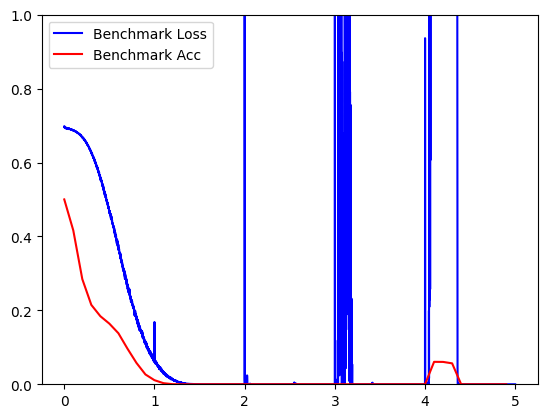

In [16]:
import matplotlib.pyplot as plt

mean_y_axis = None
mean_y_axis_short = None

for i in range(8):
    epoch_dict = standard_results[i]
    loss_arr = [epoch_dict["train_loss_arr"][i]["loss"] for i in range(len(epoch_dict["train_loss_arr"]))]
    acc_arr = [epoch_dict["train_loss_arr"][i]["test_acc"] for i in range(len(epoch_dict["train_loss_arr"]))]
    n = len(loss_arr)
    x_axis = []
    for epoch_idx, batch_losses in enumerate(loss_arr):
        x_axis.extend([epoch_idx + b_idx / len(batch_losses) for b_idx in range(len(batch_losses))])
    y_axis = []
    for j in range(n):
        y_axis.extend(loss_arr[j])
    
    x_axis_short = []
    y_axis_short = []
    for epoch_idx, batch_losses in enumerate(acc_arr):
        x_axis_short.extend([epoch_idx + sample_idx / len(batch_losses) for sample_idx in range(len(batch_losses))])
    for j in range(n):
        y_axis_short.extend(acc_arr[j])
    for j in range(len(y_axis_short)):
        y_axis_short[j] /= 1000
        y_axis_short[j] = 1-y_axis_short[j]

    if mean_y_axis is None:
        mean_y_axis = y_axis
    else:
        for j in range(len(mean_y_axis)):
            mean_y_axis[j] += y_axis[j]

    if mean_y_axis_short is None:
        mean_y_axis_short = y_axis_short
    else:
        for j in range(len(mean_y_axis_short)):
            mean_y_axis_short[j] += y_axis_short[j] 
    # plt.ylim(0,1)
    # plt.plot(x_axis, y_axis, color='blue', label='Benchmark Loss')
    # plt.plot(x_axis_short, y_axis_short, color='red', label='Benchmark Acc')
    # plt.legend()
    # plt.show()         

for j in range(len(mean_y_axis_short)):
    mean_y_axis_short[j] /= 8
for j in range(len(mean_y_axis)):
    mean_y_axis[j] /= 8

# plt.ylim(0,1)
# plt.plot(x_axis, mean_y_axis, color='blue', label='Benchmark Loss')
# plt.plot(x_axis_short, mean_y_axis_short, color='red', label='Benchmark Acc')
# plt.legend()
# plt.show()

In [69]:
from experiments_log_enhanced import run_trial

seeds = [i for i in range(4)]
seeds_2 = [i+4 for i in range(4)]
hyperparams_list = [{
    "batch_size_d": 50,
    "BPTT_T_d": 20,
    "echo_step_d": 3,
    "n_epochs": 5,
    "optimizer_args": {"lr": 3e-4, "betas": (0.95, 0.95)}
}for i in range(4)]


new_results_1 = Parallel(n_jobs=4)(
    delayed(run_trial)(seed, False, **hparams)
    for seed, hparams in zip(seeds,  hyperparams_list)
)

new_results_2 = Parallel(n_jobs=4)(
    delayed(run_trial)(seed, False, **hparams)
    for seed, hparams in zip(seeds_2,  hyperparams_list)
)

new_results = new_results_1 + new_results_2

0 0 0
0 000  00 
0
 0 0
0 / 1000
0 / 1000
0 / 1000
0 / 1000
1 / 1000
1 / 1000
1 / 1000
2 / 1000
1 / 1000
2 / 1000
2 / 1000
3 / 1000
3 / 1000
3 / 1000
2 / 1000
4 / 1000
4 / 1000
4 / 1000
3 / 1000
5 / 1000
5 / 1000
5 / 1000
4 / 1000
6 / 1000
6 / 1000
6 / 1000
5 / 1000
7 / 1000
7 / 1000
7 / 1000
8 / 1000
8 / 1000
6 / 1000
8 / 1000
9 / 1000
9 / 1000
9 / 1000
7 / 1000
10 / 1000
10 / 1000
10 / 1000
8 / 1000
11 / 1000
11 / 1000
11 / 1000
9 / 1000
12 / 1000
12 / 1000
12 / 1000
10 / 1000
13 / 1000
13 / 1000
13 / 1000
14 / 1000
14 / 1000
14 / 1000
11 / 1000
15 / 1000
15 / 1000
15 / 1000
12 / 1000
16 / 1000
16 / 1000
16 / 1000
13 / 1000
17 / 1000
17 / 1000
17 / 1000
14 / 1000
18 / 1000
18 / 1000
18 / 1000
15 / 1000
19 / 1000
19 / 1000
19 / 1000
20 / 1000
20 / 1000
20 / 1000
16 / 1000
21 / 1000
21 / 1000
21 / 1000
17 / 1000
22 / 1000
22 / 1000
22 / 1000
18 / 1000
23 / 1000
23 / 1000
23 / 1000
19 / 1000
24 / 1000
24 / 1000
24 / 1000
25 / 1000
20 / 1000
25 / 1000
25 / 1000
26 / 1000
26 / 1000
26 / 1

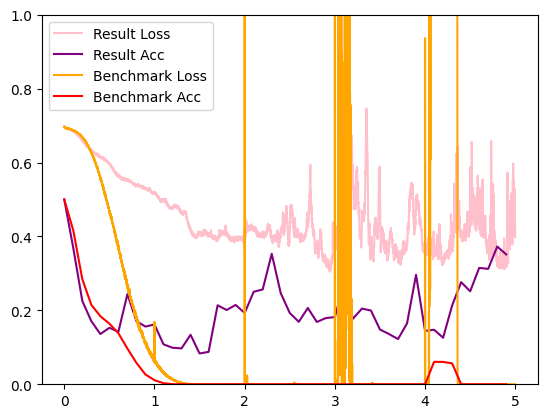

In [70]:
import matplotlib.pyplot as plt


mean_y_axis_new = None
mean_y_axis_short_new = None

for i in range(8):
    epoch_dict = new_results[i]
    loss_arr = [epoch_dict["train_loss_arr"][i]["loss"] for i in range(len(epoch_dict["train_loss_arr"]))]
    acc_arr = [epoch_dict["train_loss_arr"][i]["test_acc"] for i in range(len(epoch_dict["train_loss_arr"]))]
    n = len(loss_arr)
    x_axis = []
    for epoch_idx, batch_losses in enumerate(loss_arr):
        x_axis.extend([epoch_idx + b_idx / len(batch_losses) for b_idx in range(len(batch_losses))])
    y_axis = []
    for j in range(n):
        y_axis.extend(loss_arr[j])
    
    x_axis_short = []
    y_axis_short = []
    for epoch_idx, batch_losses in enumerate(acc_arr):
        x_axis_short.extend([epoch_idx + sample_idx / len(batch_losses) for sample_idx in range(len(batch_losses))])
    for j in range(n):
        y_axis_short.extend(acc_arr[j])
    for j in range(len(y_axis_short)):
        y_axis_short[j] /= 1000
        y_axis_short[j] = 1-y_axis_short[j]

    if mean_y_axis_new is None:
        mean_y_axis_new = y_axis
    else:
        for j in range(len(mean_y_axis_new)):
            mean_y_axis_new[j] += y_axis[j]

    if mean_y_axis_short_new is None:
        mean_y_axis_short_new = y_axis_short
    else:
        for j in range(len(mean_y_axis_short_new)):
            mean_y_axis_short_new[j] += y_axis_short[j]       

    # plt.ylim(0,1)
    # plt.plot(x_axis, y_axis, color='blue', label='Benchmark Loss')
    # plt.plot(x_axis_short, y_axis_short, color='red', label='Benchmark Acc')
    # plt.legend()
    # plt.show()    

for j in range(len(mean_y_axis_short_new)):
    mean_y_axis_short_new[j] /= 8
for j in range(len(mean_y_axis)):
    mean_y_axis_new[j] /= 8

plt.ylim(0,1)
plt.plot(x_axis, mean_y_axis_new, color='pink', label='Result Loss')
plt.plot(x_axis_short, mean_y_axis_short_new, color='purple', label='Result Acc')
plt.plot(x_axis, mean_y_axis, color='orange', label='Benchmark Loss')
plt.plot(x_axis_short, mean_y_axis_short, color='red', label='Benchmark Acc')
plt.legend()
plt.show()

### 3.1 Interpreting the above graph

The purple line and pink line are the test_acc and train_loss respectively, optimized using my algorithm across 5 epochs. This is averaged across 8 different trials (seeds 0-7).

The red line and orange line are the test_acc and train_loss respectively, optimized using a single Adam optimizer across 5 epochs. This is averaged across 8 different trials (seeds 0-7).

As you can see, my optimization algorithm helps reduce test_acc pretty quickly (faster than the vanilla Adam optimizer), but the train_loss never goes very low, and it is apparent that model blows up by the end of the first epoch.

Also, occassionally a benchmark trial will blow up out of nowhere, but then quickly go back to its former performance. It just happens, I don't exactly know why, but that explains the spikes of orange.

## 4. Discussion
There are a few reasons why I think this optimizer doesn't work yet, and some future directions to puruse

### 4.1 You don't want a $\Theta(lr)$ parameter update
Recall we are working with $g_{t, k} = \frac{dL_t}{dh_k}\frac{d^+h_k}{d\theta}$. Now our update for $\theta$ after receiving this gradient has a magnitude $\Theta(lr)$, due to Adam's mechanics. However, consider the case when $g_{t,k}$ is really small, then updating $\theta$ by a $\Theta(lr)$ sized update will only change $L_t$ by roughly $g_{t,k}*lr$. Maybe the "proper" optimization rule is to make $g_{t,k}*lr = \Theta(1)$. A qualitative explanation is that a $\Theta(lr)$ parameter update just isn't well conditioned, and having a $\Theta(lr)$ update can cause very sudden or very miniscule changes to the loss depending on the gradient. 

However, this problem isn't really the main focus of our research (giving different layers equal votes). Rather it seems like a very general research problem which I don't think would yield the largest benefits for the problem at hand (it probably is worthy of studying all by itself though).

### 4.2 There is too much noise in the loss landscape by doing all these updates at once
Consider the plots below. BM stands for the benchmark model, and Diff $\Delta$ stands for the accumulation of gradients $\sum_i \frac{dL_{k+\Delta}}{dx_k}\frac{d^+x_k}{d\theta}$ (I should probably rename these plots). And what is being plotted in grey is the cosine similarity of gradient updates between batch $i$ and batch $i+1$, where the idea is that if the cosine similarity is $1$, then the gradients move in the same direction from batch-to-batch, and there is less noise involved. The red line is a moving average of the past 20 cosine similarities.

In theory, Adam's SNR aspect should be tuning out noisy gradients (and the step sizes when gradients are noisy should be small), but maybe my beta's are too large or $\frac{1}{\sqrt{1 + x^2}}$ doesn't decrease fast enough. You can see this noise, especially in diffs 3, 4, 5, in the first epoch, where the cosine similarity oscillates between -1 and 1, suggesting that it really doesn't know the right direction to step. These moderately sized updates might be confusing the loss landscapes of other optimizers, i.e. by giving every $\Delta$ the same voting power, we are listening to very noisy gradients.

### 4.3 Next Steps
The first thing I want to do is try an optimizer that is different from Adam. Maybe SGD with the $L_p$ normalization. The idea is that Adam is not guaranteed to converge, and often pushes for better minima (thanks to Alf for the idea). Asking ChatGPT confirms this, and cites a paper Reddi et. al "On the Convergence of Adam and Beyond." Maybe using AMSGrad, which does have convergence guarantees would be helpful. I believe that this is my main problem, because as you can see in the appendix, $W_{hh}$ consistently grows, and if I don't use gradient clipping, the gradient magnitudes will grow well into the 100s.

Another idea closely related to 4.2, is to consider each direction a layer or a $\Delta$ wants to move in, and reweight these based on how noisy the past gradients have been. This would avoid the problem of giving super noisy gradients such as diffs 3, 4, and 5 equal votes and making parameter steps noisy. That would be another thing to explore, but fixing the blow up is a prerequisite to exploring this.

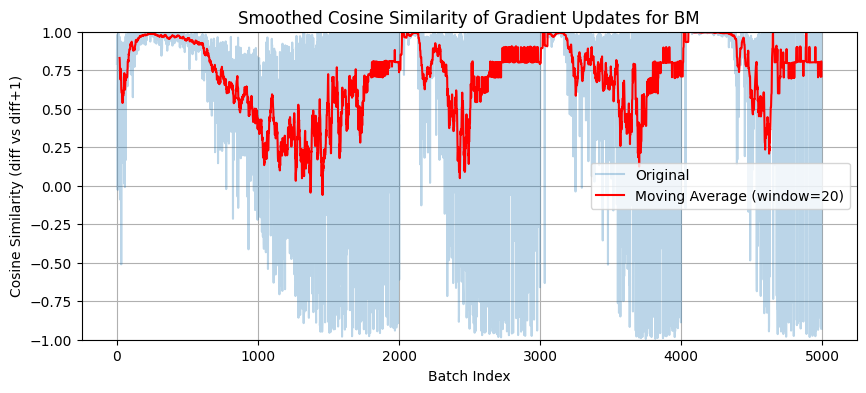

In [71]:
import torch
import matplotlib.pyplot as plt
import numpy as np

diff_1 = 4
diff_2 = 3
window_size = 20  # moving average window, adjust as needed

num_batches = len(standard_results[1]["train_loss_arr"][0]["grad"])
num_epochs = len(standard_results[0]["train_loss_arr"])
cos_sims = []

for epoch in range(num_epochs):
    for batch_idx in range(num_batches-1):
        # Can either have this like (batch_idx, diff_1) vs (batch_idx+1, diff_1)
        # Or can have it like (batch_idx, diff)

        grad_1_dict = standard_results[2]["train_loss_arr"][epoch]["grad"][batch_idx]
        grad_2_dict = standard_results[2]["train_loss_arr"][epoch]["grad"][batch_idx + 1]
        
        # if batch_idx == 950:
        #     print(grad_1_dict)

        # Flatten all parameter gradients into single vectors
        grad_1_vec = torch.cat([
            g['grad'].flatten() if g['grad'] is not None and name == "rnn_cell.weight_hh" else torch.zeros_like(g['param']).flatten()
            for name, g in grad_1_dict.items()
        ])
        grad_2_vec = torch.cat([
            g['grad'].flatten() if g['grad'] is not None and name == "rnn_cell.weight_hh" else torch.zeros_like(g['param']).flatten()
            for name, g in grad_2_dict.items()
        ])    
        # Cosine similarity
        cos_sim = torch.nn.functional.cosine_similarity(grad_1_vec, grad_2_vec, dim=0)
        cos_sims.append(cos_sim.item())

# Convert to numpy array for smoothing
cos_sims = np.array(cos_sims)

# Moving average
smoothed = np.convolve(cos_sims, np.ones(window_size)/window_size, mode='valid')

# Plot
plt.figure(figsize=(10,4))
plt.ylim(-1,1)
plt.plot(cos_sims, alpha=0.3, label='Original')
plt.plot(np.arange(window_size-1, num_epochs*(num_batches-1)), smoothed, color='red', label=f'Moving Average (window={window_size})')
plt.xlabel("Batch Index")
plt.ylabel("Cosine Similarity (diff vs diff+1)")
plt.title(f"Smoothed Cosine Similarity of Gradient Updates for BM")
plt.grid(True)
plt.legend()
plt.show()


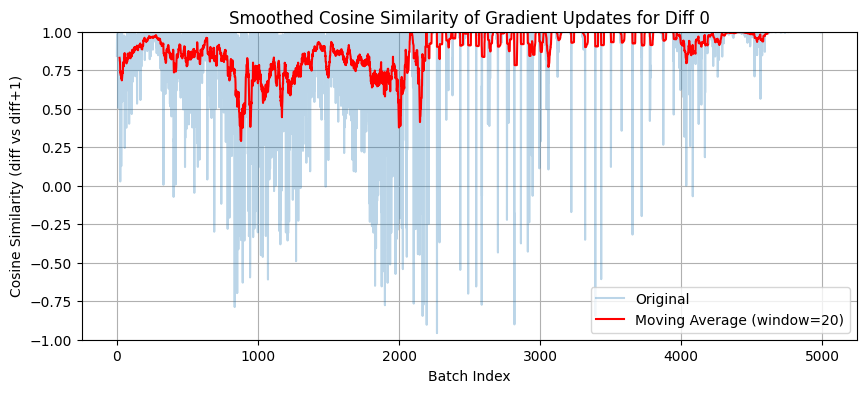

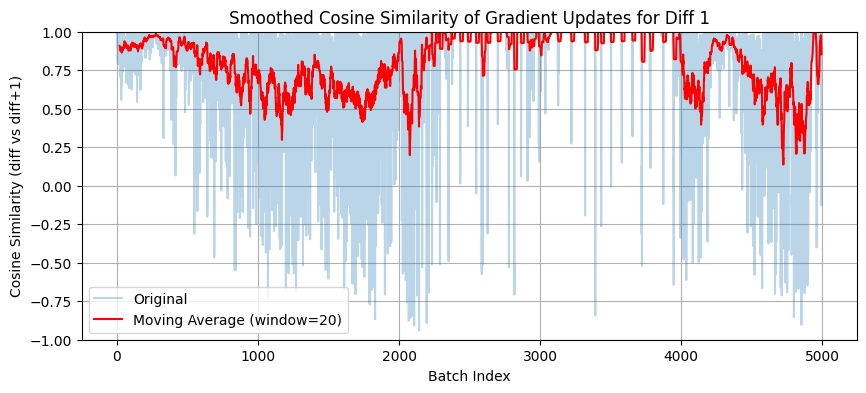

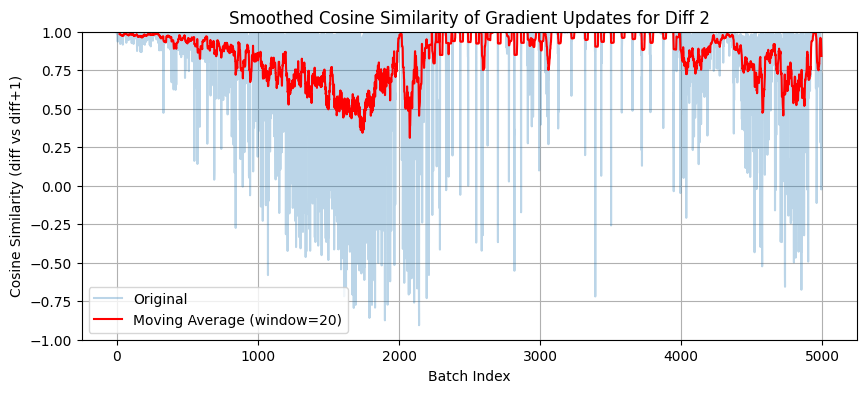

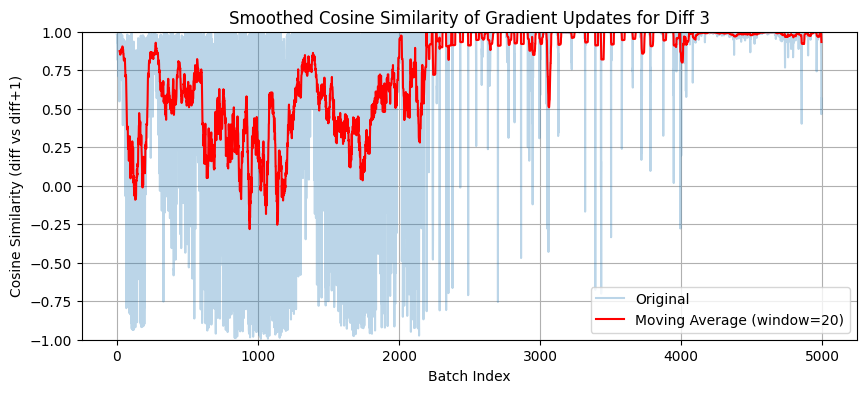

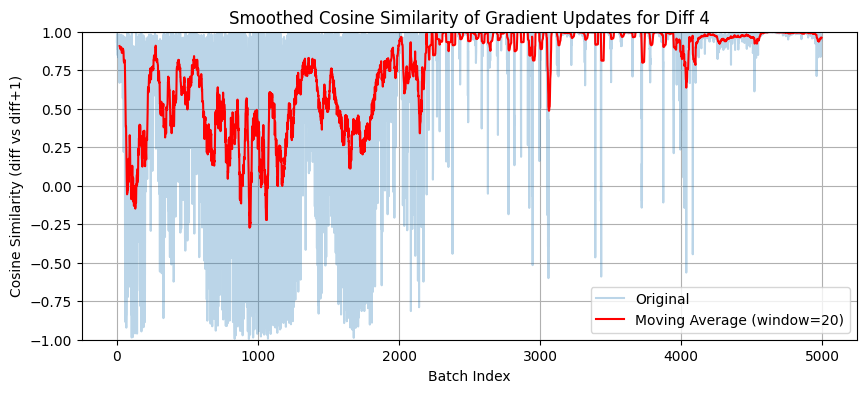

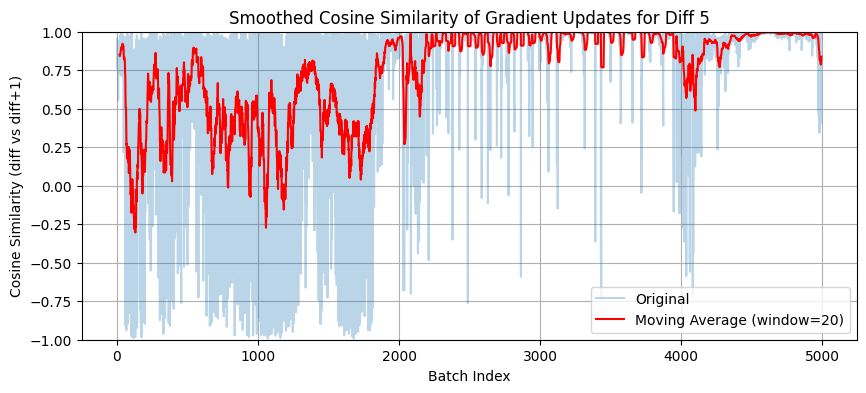

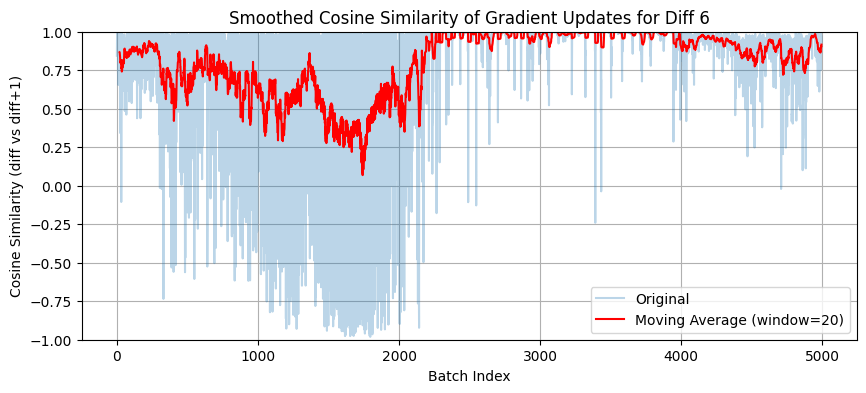

In [72]:
import torch
import matplotlib.pyplot as plt
import numpy as np

sample = 0 # 0 through 7

for diff_1 in range(7):
    window_size = 20  # moving average window, adjust as needed

    num_batches = len(new_results[1]["train_loss_arr"][0]["grad"])
    num_epochs = len(new_results[0]["train_loss_arr"])
    cos_sims = []

    for epoch in range(num_epochs):
        for batch_idx in range(num_batches-1):
            # Can either have this like (batch_idx, diff_1) vs (batch_idx+1, diff_1)
            # Or can have it like (batch_idx, diff)

            grad_1_dict = new_results[7]["train_loss_arr"][epoch]["grad"][batch_idx][diff_1]
            grad_2_dict = new_results[7]["train_loss_arr"][epoch]["grad"][batch_idx + 1][diff_1]
            
            # if batch_idx == 950:
            #     print(grad_1_dict)

            # Flatten all parameter gradients into single vectors
            grad_1_vec = torch.cat([
                g['grad'].flatten() if g['grad'] is not None and name == "rnn_cell.weight_hh" else torch.zeros_like(g['param']).flatten()
                for name, g in grad_1_dict.items()
            ])
            grad_2_vec = torch.cat([
                g['grad'].flatten() if g['grad'] is not None and name == "rnn_cell.weight_hh" else torch.zeros_like(g['param']).flatten()
                for name, g in grad_2_dict.items()
            ])    
            # Cosine similarity
            cos_sim = torch.nn.functional.cosine_similarity(grad_1_vec, grad_2_vec, dim=0)
            cos_sims.append(cos_sim.item())

    # Convert to numpy array for smoothing
    cos_sims = np.array(cos_sims)

    # Moving average
    smoothed = np.convolve(cos_sims, np.ones(window_size)/window_size, mode='valid')

    # Plot
    plt.figure(figsize=(10,4))
    plt.ylim(-1,1)
    plt.plot(cos_sims, alpha=0.3, label='Original')
    plt.plot(np.arange(window_size-1, num_epochs*(num_batches-1)), smoothed, color='red', label=f'Moving Average (window={window_size})')
    plt.xlabel("Batch Index")
    plt.ylabel("Cosine Similarity (diff vs diff+1)")
    plt.title(f"Smoothed Cosine Similarity of Gradient Updates for Diff {diff_1}")
    plt.grid(True)
    plt.legend()
    plt.show()


### Appendix
I had to include gradient clipping because otherwise gradients would explode wildly. This still doesn't seem to have fixed the issue

1000


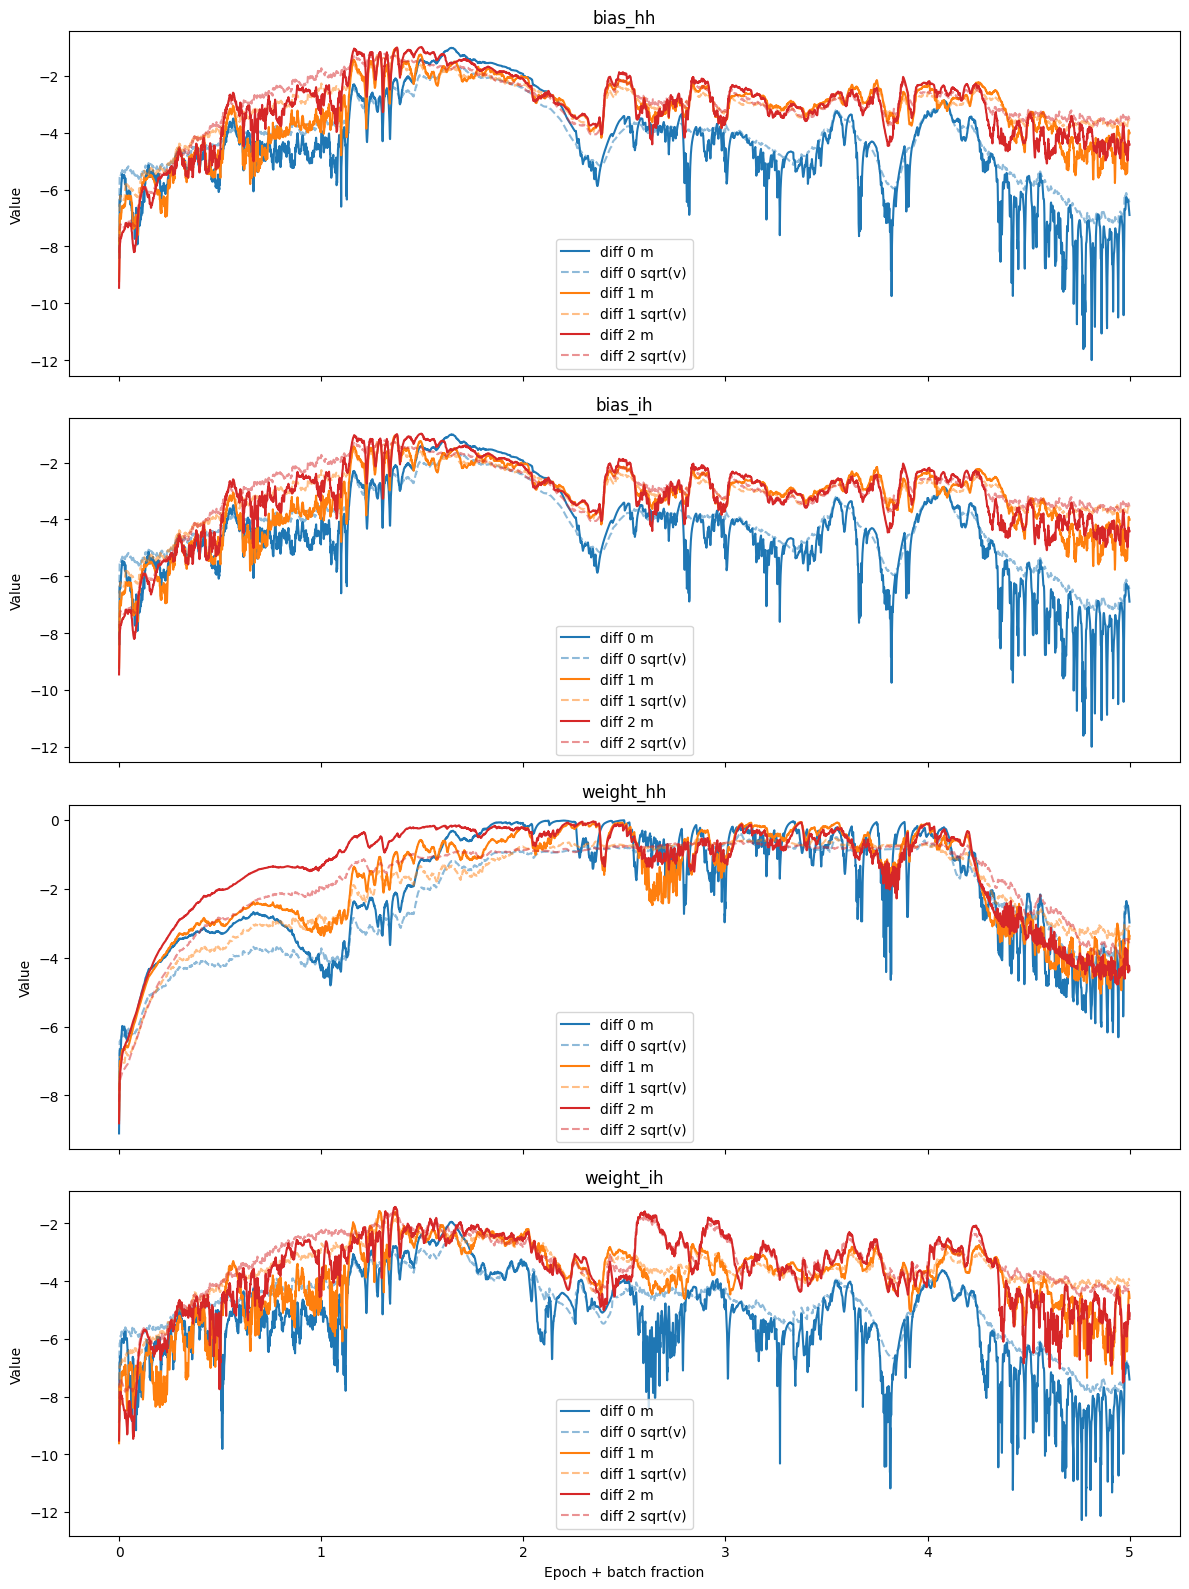

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Example: data shape [epochs][batches][diffs][{param_name: (m, v)}]
data = new_results[2]["train_loss_arr"]

epochs = 5
batches_per_epoch = len(data[0]["optim"])
print(batches_per_epoch)
diffs = len(data[0]["optim"][0])
param_names = list(data[0]["optim"][0][0].keys())  # assume all dicts have same keys
param_names = sorted(set(param_names) - set(["diff"]))

colors = plt.cm.tab10(np.linspace(0, 1, diffs))

fig, axes = plt.subplots(len(param_names), 1, figsize=(12, 4 * len(param_names)), sharex=True)

if len(param_names) == 1:
    axes = [axes]  # make iterable

for ax, param in zip(axes, param_names):
    if param == 'diff':
        continue
    for diff_idx in range(diffs):
        if diff_idx > 2:
            continue
        x_vals = []
        m_vals = []
        sqrt_v_vals = []
        for epoch_idx in range(epochs):
            for batch_idx in range(batches_per_epoch):
                fraction = epoch_idx + batch_idx / batches_per_epoch
                x_vals.append(fraction)
                m, v = data[epoch_idx]["optim"][batch_idx][diff_idx][param]['norm_exp_avg'], data[epoch_idx]["optim"][batch_idx][diff_idx][param]['norm_exp_avg_sq']
                
                # Lets do Log instead
                m_vals.append(np.log(m))
                sqrt_v_vals.append(np.log(np.sqrt(v)))
        # plot m (dark)
        ax.plot(x_vals, m_vals, color=colors[diff_idx], label=f'diff {diff_idx} m')
        # plot sqrt(v) (light)
        ax.plot(x_vals, sqrt_v_vals, color=colors[diff_idx], linestyle='--', alpha=0.5, label=f'diff {diff_idx} sqrt(v)')

    ax.set_title(param)
    ax.set_ylabel('Value')
    ax.legend()

axes[-1].set_xlabel('Epoch + batch fraction')

# plt.set_title("Tracking Inner State of Adam Optimizer")
plt.tight_layout()
plt.show()
